In [230]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

%matplotlib inline

## Drawing Maps

The following function draws a map following the provided boundaries. If a dataset is provided, it also shows the dataset value associated with each area in the map. Due to problems with Chrome, we save the map with the chosen filename, instead of visualizing it on the notebook.

In [231]:
def plot_map(geo_df, area_name="community", data=None, column_name="values", map_name="map.html"):
    m = folium.Map(location=[41.8755616, -87.6244212], tiles='Mapbox Bright', zoom_start=11) ## This location is Chicago
    
    if data is None:
        folium.GeoJson(
            geo_df,
            name='geojson'
        ).add_to(m)
    else:
        #bins = list(data.quantile(np.linspace(0, 1, 15))) ## to use bins, gotta check fill_color
        folium.Choropleth(
            geo_data=geo_df,
            name='choropleth',
            data=data,
            columns=[area_name, column_name],
            key_on='feature.properties.{}'.format(area_name),
            fill_color='YlGnBu',
            fill_opacity=0.7,
            line_opacity=0.2
            #bins=bins
        ).add_to(m)
        
    m.save("maps/" + map_name)

## Community Areas

This dataset was provided by the city of Chicago's government. It divides the city into community areas. Throughout our project, we use these community areas as neighborhoods about which we will present and study correlations between food quality and socio-economical variables.

In [245]:
import os
print(os.getcwd())
geo_df = gpd.read_file("data/chicago_boundaries_community_area.geojson")
geo_df.head()

/home/kenkobz/.local/share/Trash/files/Food-Quality-and-Social-Groups-in-Chicago


DriverError: data/chicago_boundaries_community_area.geojson: No such file or directory

In [233]:
geo_df = geo_df[["community", "shape_area", "shape_len", "geometry"]]
len(geo_df)

77

In [234]:
plot_map(geo_df, "community", map_name="boundary.html")

In [243]:
import IPython
#IPython.display.HTML(filename='maps/boundary.html')
#IPython.display.HTML('<iframe src=' + 'maps/boundary.html' + ' width=100% height=1000></iframe>')
IPython.display.IFrame(src='maps/boundary.html', width=1000, height=1000)
#display(HTML('<iframe src=' + boundary.html + ' width=100% height=1000></iframe>'))

## Assigning Coordinates to Community Area

We define the following functions in order to assign a coordinate (i.e., a food inspection location) to the community area in which it is located. If a point is not inside any community area (e.g., in the boundary), we assign it to the nearest one.

In [6]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'community']

## key: key that will be used to join
def assign_community(geo_df, data, latitude="latitude", longitude="longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data, 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh['community'])]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found['community'] = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh['community'])])))
    
    columns_to_return = list(data.columns) + ["community"]
    return points_to_neigh[columns_to_return]

## Census Data

In order to normalize our results and analyze food quality prejudice by color, we also obtained information of the latest census conducted in Chicago.

In [7]:
census = pd.read_csv("data/census.csv", header=1)
census.head()

,Community,Community Number,Total Population,Age 0‐2,Age 3‐4,Age 5,Age 6‐12,Families with a child under age 6,Percent Hispanic,Percent Non‐ Hispanic Black,Percent Non‐ Hispanic White,Percent Non‐ Hispanic Asian,Percent Non‐ Hispanic Other or Multiple Races,Children 0‐5,Children 6‐17,Children 0‐5.1,Children 6‐11,Children 0‐5.2,Children 6‐11.1,Unnamed: 19
0,Rogers Park,1.0,"53,470","2,164","1,166",616,"3,819","2,708",24%,24%,45%,5%,3%,63%,61%,29%,35%,46%,70%,NaN
1,West Ridge,2.0,"75,185","3,507","2,075","1,095","7,957","4,293",20%,13%,41%,21%,4%,55%,67%,34%,40%,54%,61%,NaN
2,Uptown,3.0,"54,001","1,647",884,370,"2,681","2,053",16%,19%,51%,11%,3%,72%,61%,24%,32%,40%,70%,NaN
3,Lincoln Square,4.0,"46,881","2,163",902,324,"2,380","2,380",18%,6%,62%,10%,4%,59%,72%,14%,21%,27%,31%,NaN
4,North Center,5.0,"35,406","2,043","1,076",636,"2,873","2,468",11%,9%,73%,4%,3%,73%,77%,5%,7%,8%,15%,NaN


In [8]:
columns_to_keep = ["Community", "Total Population", "Percent Hispanic", "Percent Non‐ Hispanic Black",
                   "Percent Non‐ Hispanic White", "Percent Non‐ Hispanic Asian",
                   "Percent Non‐ Hispanic Other or Multiple Races"]
census = census[columns_to_keep]
census.columns = ["community", "population", "hispanic", "black", "white", "asian", "other"]

census = census.drop(census.tail(1).index)

In [9]:
races = ["hispanic", "black", "white", "asian", "other"]
census[races] = census[races].apply(lambda x: x.str.replace("%", "").astype("int32"), axis=0)
census["population"] = census["population"].str.replace(",", "").astype("int32")
census["community"] = census["community"].str.upper()
census.head()

,community,population,hispanic,black,white,asian,other
0,ROGERS PARK,53470,24,24,45,5,3
1,WEST RIDGE,75185,20,13,41,21,4
2,UPTOWN,54001,16,19,51,11,3
3,LINCOLN SQUARE,46881,18,6,62,10,4
4,NORTH CENTER,35406,11,9,73,4,3


In [10]:
census.loc[census['community'] == "O'HARE", 'community'] = 'OHARE'

In [11]:
set(geo_df["community"]) == set(census["community"])

True

## Food Inspections in Chicago

The main dataset in our project contains information about food inspections in the city of Chicago from 2010 to the present. We use the results of food inspections as a proxy of food quality in a certain community.

We drop inspections from our dataset if:
* The inspection does not indicate a pass or a failure, since we cannot evaluate the food quality without this information.
* The inspection does not assign a risk to a inspections/establishment, since we cannot evaluate the food quality without this information.
* The inspection does not have a location (i.e., latitude and longitude) because we cannot assign it to a community.

In [29]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2201126,NEW CHINA WOK,NEW CHINA WOK,2621123.0,Restaurant,Risk 1 (High),752 W GARFIELD BLVD,CHICAGO,IL,60609.0,2018-08-17T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.794417,-87.644816,"{'longitude': '-87.64481608216055', 'needs_rec..."
1,2201124,FANNIE SCHMOE'S BAKERY,FANNIE'S CAFE,2432423.0,Restaurant,Risk 1 (High),5040-5044 W Montrose AVE,CHICAGO,IL,60641.0,2018-08-17T00:00:00,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.960745,-87.754004,"{'longitude': '-87.75400366103027', 'needs_rec..."
2,2201123,"NEWPORT ACADEMY, INC.",NEWPORT CHILDREN'S ACADEMY,2458128.0,Children's Services Facility,Risk 1 (High),1819-1825 W NEWPORT AVE,CHICAGO,IL,60657.0,2018-08-17T00:00:00,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.944061,-87.674704,"{'longitude': '-87.67470356794354', 'needs_rec..."
3,2201122,YEFSEIS,YEFSEIS,2617529.0,NaN,Risk 1 (High),3344 N HALSTED ST,CHICAGO,IL,60657.0,2018-08-17T00:00:00,License,Not Ready,NaN,41.943130,-87.649512,"{'longitude': '-87.64951168839137', 'needs_rec..."
4,2201116,"EASTSIDE SHARKS, INC.",SHARKS,1545884.0,Restaurant,Risk 2 (Medium),100 E 79TH ST,CHICAGO,IL,60619.0,2018-08-17T00:00:00,Complaint,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.751118,-87.621307,"{'longitude': '-87.62130733246569', 'needs_rec..."


In [30]:
columns_to_keep = ["Inspection ID", "DBA Name", "AKA Name", "Risk", "Results", "Latitude", "Longitude", "Violations", "Inspection Date"]
inspections = inspections[columns_to_keep]
inspections.columns = ["inspection_id", "dba_name", "aka_name", "risk", "results", "latitude", "longitude", "violations", "date"]
inspections.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'risk', 'results', 'latitude',
       'longitude', 'violations', 'date'],
      dtype='object')

In [31]:
def map_risk(x_):
    x = str(x_)
    if "High" in x:
        return 3
    elif "Medium" in x:
        return 2
    elif "Low" in x:
        return 1
    else:
        return x
    
def map_n_violations(x_):
    x = str(x_)
    return x.split(".")[0]
    
inspections["date"] = pd.to_datetime(inspections["date"])
inspections = inspections.dropna(subset=["latitude", "longitude"])
inspections = inspections[inspections["results"].isin(["Pass", "Pass w/ Conditions", "Fail"])]
inspections["risk"] = inspections["risk"].apply(map_risk)
inspections = inspections[inspections["risk"].isin([1, 2, 3])]
inspections["risk"] = inspections["risk"].astype("int16")
inspections["n_violations"] = inspections["violations"].fillna(0).apply(map_n_violations)
inspections["n_violations"] = inspections["n_violations"].astype("int32")
inspections.head()

,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations
0,2201126,NEW CHINA WOK,NEW CHINA WOK,3,Pass w/ Conditions,41.794417,-87.644816,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3
1,2201124,FANNIE SCHMOE'S BAKERY,FANNIE'S CAFE,3,Pass w/ Conditions,41.960745,-87.754004,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3
2,2201123,"NEWPORT ACADEMY, INC.",NEWPORT CHILDREN'S ACADEMY,3,Pass w/ Conditions,41.944061,-87.674704,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3
4,2201116,"EASTSIDE SHARKS, INC.",SHARKS,2,Pass w/ Conditions,41.751118,-87.621307,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3
5,2201104,GLENN'S DINER,GLENN'S DINER,3,Pass,41.961612,-87.675437,NaN,2018-08-17,0


In [32]:
inspections_community = assign_community(geo_df, inspections, verbose=True)
inspections_community.head()

There are 2279 points without an exact neighborhood
There are 0 points without an exact neighborhood


C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations,geometry,community
0,2201126,NEW CHINA WOK,NEW CHINA WOK,3,Pass w/ Conditions,41.794417,-87.644816,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3,POINT (-87.64481608216055 41.79441676779757),NEW CITY
1,2201124,FANNIE SCHMOE'S BAKERY,FANNIE'S CAFE,3,Pass w/ Conditions,41.960745,-87.754004,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3,POINT (-87.75400366103027 41.9607447637819),PORTAGE PARK
2,2201123,"NEWPORT ACADEMY, INC.",NEWPORT CHILDREN'S ACADEMY,3,Pass w/ Conditions,41.944061,-87.674704,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3,POINT (-87.67470356794355 41.94406143097434),NORTH CENTER
4,2201116,"EASTSIDE SHARKS, INC.",SHARKS,2,Pass w/ Conditions,41.751118,-87.621307,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2018-08-17,3,POINT (-87.62130733246569 41.75111814085375),GREATER GRAND CROSSING
5,2201104,GLENN'S DINER,GLENN'S DINER,3,Pass,41.961612,-87.675437,NaN,2018-08-17,0,POINT (-87.67543734575274 41.96161213476741),LINCOLN SQUARE


SEPARATE BY YEAR LATER

The following maps show:
1. The log-number of inspections in each community per 100 citizens.
2. Rate of inspection failure by community.
3. A community's average risk of an establishment adversely affecting the public’s health in the range [0, 3], with three indicating a higher risk.
4. The average number of food inspection violations in each community per 100 citizens.
5. The number of inspections in each community normalized by number of establishments in our dataset.
6. The number of violations in each community normalized by number of establishments in our dataset.

In [33]:
population_community = census[["community", "population"]].set_index("community")["population"]
n_establishments = inspections_community.groupby("community")["dba_name"].nunique()

In [34]:
## 1) Number of inspections per 100 citizens
## We use log because... (gotta check if power law, but we need to use log or smth (log might not be the best))
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
n_inspections_per_capita = n_inspections.div(population_community) * 100
plot_map(geo_df, data=np.log(n_inspections_per_capita), map_name="n_inspections.html")

In [35]:
## 2) Rate of failure
neigh_results = inspections_community.groupby(["community", "results"]).count()["inspection_id"].rename("values")
percentage_results = (neigh_results.div(n_inspections) * 100).reset_index()
failure_community = percentage_results[percentage_results["results"]=="Fail"]
failure_community = failure_community.drop("results", axis="columns").set_index("community")["values"]
plot_map(geo_df, data=failure_community, map_name="rate_failure.html")

In [36]:
## 3) Average risk
average_risk = inspections_community.groupby("community").mean()["risk"].rename("values")
plot_map(geo_df, data=average_risk, map_name="average_risk.html")

In [37]:
## 4) Number of violations per capita (10000)
## We use log because... (gotta check if power law, but we need to use log or smth (log might not be the best))
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
average_violations_per_capita = average_violations.div(population_community) * 10000
plot_map(geo_df, data=np.log(average_violations_per_capita), map_name="average_n_violations.html")

In [38]:
## 5) # inspections / # establishments
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
norm_n_inspections = n_inspections.div(n_establishments)
plot_map(geo_df, data=norm_n_inspections, map_name="n_inspections_per_establish.html")

In [39]:
## 4) Number of violations / # establishments
## We use log because... (gotta check if power law, but we need to use log or smth (log might not be the best))
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
norm_average_violations = average_violations.div(n_establishments)
plot_map(geo_df, data=np.log(norm_average_violations), map_name="average_n_violations_per_establish.html")

## Hardship Index

The city of Chicago also makes available the economic hardship of all its community areas. The economic hardship index is a function of:

1. Unemployment (over the age of 16 years),
2. Education (over 25 years of age without a high school
diploma)
3. Per capita income level
4. Poverty (below the federal poverty level)
5. Crowded housing (housing units with more than one person
per room)
6. Dependency (population under 18 or over 64 years of age)

We will use the economic hardship index as a measurement of economic conditions of each community area in Chicago. A higher index indicates poorer conditions. For more information on the index: https://greatcities.uic.edu/wp-content/uploads/2016/07/GCI-Hardship-Index-Fact-SheetV2.pdf

In [24]:
income_df = pd.read_csv("data/Per_Capita_Income.csv")
income_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [25]:
income_df.columns = ['community_number','community','percentage_housing_crowded','percent_households_below_poverty','percent_aged_16+_unemployed','percent_aged_25+_without_highschool_diploma','percent_aged_under_18_or_over_64','per_capita_income','hardship_index']
income_df["community"].unique

<bound method Series.unique of 0         Rogers Park
1          West Ridge
2              Uptown
3      Lincoln Square
4        North Center
           ...       
73    Mount Greenwood
74        Morgan Park
75             O'Hare
76          Edgewater
77            CHICAGO
Name: community, Length: 78, dtype: object>

In [26]:
income_df = income_df[income_df["community"] != 'CHICAGO']
income_df["community"] = income_df["community"].str.upper()

In [27]:
set(geo_df["community"]) == set(income_df["community"])

False

In [28]:
set(geo_df["community"]) - set(income_df["community"])

{'MONTCLARE', 'OHARE', 'WASHINGTON HEIGHTS'}

In [29]:
set(income_df["community"]) - set(geo_df["community"])

{'MONTCLAIRE', "O'HARE", 'WASHINGTON HEIGHT'}

In [30]:
income_df.loc[income_df['community'] == "O'HARE", 'community'] = 'OHARE'
income_df.loc[income_df['community'] == "MONTCLAIRE", 'community'] = 'MONTCLARE'
income_df.loc[income_df['community'] == "WASHINGTON HEIGHT", 'community'] = 'WASHINGTON HEIGHTS'
set(geo_df["community"]) == set(income_df["community"])

True

We normalize hardship into a [0, 1] range for our analysis. Since hardship is not a concept easy to understand as it is a function of many economic variables, we believe that comparing between communities will be easier after normalizing the index.

In [31]:
delta_hardship = income_df["hardship_index"].max() - income_df["hardship_index"].min()
income_df["hardship_index"] = income_df["hardship_index"]/delta_hardship

In [32]:
hardship = income_df[["community", "hardship_index"]].set_index("community").rename(columns={"hardship_index": "values"})["values"]
plot_map(geo_df, data=hardship, map_name="hardship.html")

# Hypotheses

### 1) Correlation Between Race and Food Quality

Explain hypothesis here

In [34]:
def plot_correlation_food_variables(food_quality_index=None, index_name="",
                                    variables_df=None, variables=None, variable_name="", method="pearson"):
    correlations = []
    for var in variables:
        var_community = variables_df[["community", var]].set_index("community")[var]
        correlations.append(var_community.corr(food_quality_index, method=method))
    plt.bar(x=variables, height=correlations)
    plt.title("Correlation between {} and {}".format(variable_name, index_name))

In [35]:
def scatter_plot_with_line(food_quality_index=None, index_name="",
                           variable_df=None, variable_name="", method="pearson"):
    plt.ylabel(index_name)
    plt.xlabel(variable_name)
    plt.scatter(variable_df, food_quality_index)

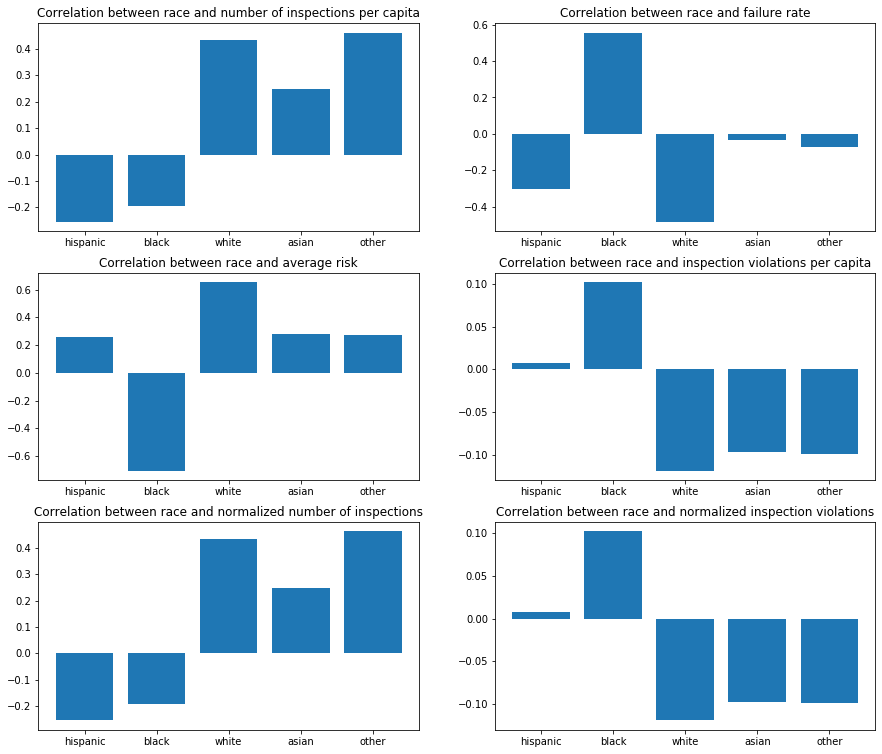

In [36]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
plot_correlation_food_variables(norm_n_inspections, index_name="number of inspections per capita",
                                variables_df=census, variables=races, variable_name="race")

## 2) Rate of failure
plt.subplot(3, 2, 2)
plot_correlation_food_variables(failure_community, index_name="failure rate",
                                variables_df=census, variables=races, variable_name="race")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
plot_correlation_food_variables(average_risk, index_name="average risk",
                                variables_df=census, variables=races, variable_name="race")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
plot_correlation_food_variables(norm_average_violations, index_name="inspection violations per capita",
                                variables_df=census, variables=races, variable_name="race")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
plot_correlation_food_variables(norm_n_inspections, index_name="normalized number of inspections",
                                variables_df=census, variables=races, variable_name="race")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
plot_correlation_food_variables(norm_average_violations, index_name="normalized inspection violations",
                                variables_df=census, variables=races, variable_name="race")

Apparently, the black population lived in community areas with lower quality of food, a higher number of inspection violations and a lower number of inspections.


### The scatterplot 1 and 5 are the same
### same for 4 and 6

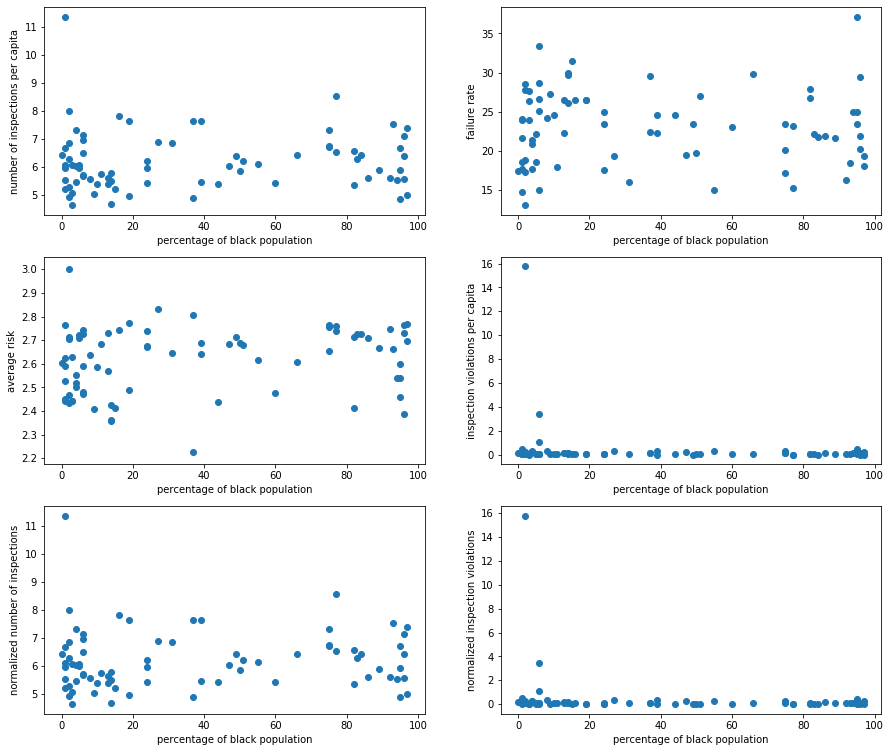

In [37]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita

plt.subplot(3, 2, 1)
scatter_plot_with_line(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot_with_line(failure_community, index_name="failure rate",
                                variable_df=census["black"], variable_name="percentage of black population")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
scatter_plot_with_line(average_risk, index_name="average risk",
                                variable_df=census["black"], variable_name="percentage of black population")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot_with_line(norm_average_violations, index_name="inspection violations per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot_with_line(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=census["black"], variable_name="percentage of black population")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot_with_line(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=census["black"], variable_name="percentage of black population")

Unfortunately the scatterplots don't show this type of correlation. So we proceed with a significance test for our correlation.

In [43]:
def pearson_correlation_and_pvalue(x,y):
    corr, pval = pearsonr(x,y)
    print('The correlation between the variables is:', corr)
    print('The p-value of this correlation is:', pval)

In [44]:
pearson_correlation_and_pvalue(norm_n_inspections, census['black'])
pearson_correlation_and_pvalue(failure_community, census['black'])
pearson_correlation_and_pvalue(norm_average_violations, census['black'])

The correlation between the variables is: 0.057772379124486045
The p-value of this correlation is: 0.6177259377245679
The correlation between the variables is: -0.015410089575785803
The p-value of this correlation is: 0.8941782753903799
The correlation between the variables is: -0.14295304770163184
The p-value of this correlation is: 0.21487490594496791


In [81]:
test = pd.DataFrame(norm_n_inspections.values.reshape(-1,1),columns=['inspections'])
test['black']=census['black']
test.corr(method='pearson')

,inspections,black
inspections,1.000000,0.057772
black,0.057772,1.000000


# Does it really follow what we are expecting? I think we really need to run pairwise significance tests because these scatter plots are not nice.

In [53]:
census = census.set_index("community")
census["failure_rate"] = norm_n_inspections
census["dominant_race"] = census[races].idxmax(axis=1)
census.head()

,population,hispanic,black,white,asian,other,failure_rate,dominant_race
community,,,,,,,,
ROGERS PARK,53470,24,24,45,5,3,6.626424,white
WEST RIDGE,75185,20,13,41,21,4,6.595122,white
UPTOWN,54001,16,19,51,11,3,6.990000,white
LINCOLN SQUARE,46881,18,6,62,10,4,6.639810,white
NORTH CENTER,35406,11,9,73,4,3,6.240223,white


In [331]:
## If we get only the dominant race in the neighborhood, only asian-black is siginificant.
print(pairwise_tukeyhsd(census["failure_rate"], census["dominant_race"]))

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower    upper  reject
---------------------------------------------------------
   asian    black  -9.6851 0.0482 -19.3156 -0.0546   True
   asian hispanic   -9.605 0.0557 -19.3735  0.1634  False
   asian    white  -6.7008 0.2769 -16.4322  3.0307  False
   black hispanic   0.0801    0.9  -3.6507  3.8108  False
   black    white   2.9843 0.1443  -0.6485  6.6171  False
hispanic    white   2.9042 0.2303  -1.0799  6.8884  False
---------------------------------------------------------


In [334]:
## This doesnt' work for us -> fuck it
results = ols("failure_rate ~ white + black + asian + hispanic + other", data=census).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           failure_rate   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3.912
Date:                Wed, 13 Nov 2019   Prob (F-statistic):            0.00345
Time:                        22:12:48   Log-Likelihood:                -227.68
No. Observations:                  77   AIC:                             467.4
Df Residuals:                      71   BIC:                             481.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0804     85.998      0.094      0.925    -163.395     179.556
white         -0.0278      0.867     -0.032      0.975      -1.757       1.701
black         -0.0449      0.861     -0.052      0.959      -1.761       1.672
asian          0.1703      0.863      0.197      0.844      -1.551       1.892
hispanic      -0.0589      0.859     -0.069      0.946      -1.771       1.654
other          0.6265      0.983      0.638      0.526      -1.333       2.586
==============================================================================
Omnibus:                       84.953   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              921.032
Skew:                           3.374   Prob(JB):                    1.00e-200
Kurtosis:                      18.542   Cond. No.                     8.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## What we need is a pairwise comparison between correlation coefficients and I dont know how to do it. Niko?

### 2) Correlation Between Hardship and Food Quality

Explain hypothesis here

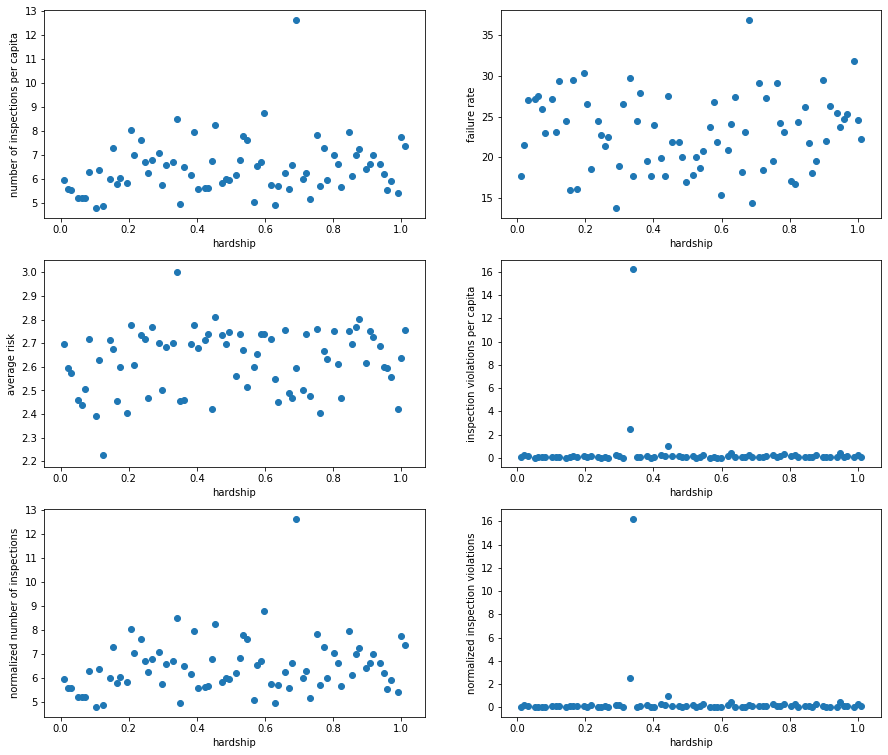

In [195]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita


plt.subplot(3, 2, 1)
scatter_plot_with_line(norm_n_inspections, index_name="number of inspections per capita",
                                variable_df=hardship, variable_name="hardship")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot_with_line(failure_community, index_name="failure rate",
                                variable_df=hardship, variable_name="hardship")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
scatter_plot_with_line(average_risk, index_name="average risk",
                                variable_df=hardship, variable_name="hardship")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot_with_line(norm_average_violations, index_name="inspection violations per capita",
                                variable_df=hardship, variable_name="hardship")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot_with_line(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=hardship, variable_name="hardship")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot_with_line(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=hardship, variable_name="hardship")

# Crime dataset investigation

In [12]:
crime_df = pd.read_csv('data/Crimes_2001-2019.csv')
crime_df.head(10)

C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,...,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


Limit the data to the period 2010-2019

In [13]:
crime_df = crime_df.loc[crime_df.Year>2009]
crime_df.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,...,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
10,11227586,JB147613,02/10/2017 12:00:00 PM,089XX S COTTAGE GROVE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,8.0,44.0,14,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [14]:
crime_df['Primary Type'].unique()

array(['CRIM SEXUAL ASSAULT', 'BURGLARY', 'THEFT',
       'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'CRIMINAL DAMAGE', 'OTHER OFFENSE', 'SEX OFFENSE', 'ASSAULT',
       'NARCOTICS', 'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
       'MOTOR VEHICLE THEFT', 'BATTERY', 'OBSCENITY',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'NON-CRIMINAL',
       'PUBLIC PEACE VIOLATION', 'INTIMIDATION', 'ARSON', 'STALKING',
       'INTERFERENCE WITH PUBLIC OFFICER',
       'CONCEALED CARRY LICENSE VIOLATION', 'KIDNAPPING',
       'HUMAN TRAFFICKING', 'HOMICIDE', 'GAMBLING', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

Some type of violation could be excluded for some resons:
- Liquor law violation is not an index of dangerous neughborhood
- Non-Criminal actions are used to code police calls that are not crimes
- Concealed carry license violation is usually found when a vehicle is in moving so we can not connect the place where is found to a neighborhood quartier

In [15]:
crime_df = crime_df[~crime_df['Primary Type'].isin(['LIQUOR LAW VIOLATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)'])]
crime_df.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,...,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
10,11227586,JB147613,02/10/2017 12:00:00 PM,089XX S COTTAGE GROVE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,8.0,44.0,14,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [16]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [17]:
crime_df['Location']

1                                    NaN
2                                    NaN
3                                    NaN
4                                    NaN
5                                    NaN
                       ...              
7001558    (41.862830429, -87.717040084)
7001559    (41.864278228, -87.659660218)
7001560    (41.864278357, -87.659682244)
7001561                              NaN
7001562                              NaN
Name: Location, Length: 2920357, dtype: object

As we can see there are many location with missing values, we are going to fill these holes by assigning to them a point in the community area where the crimes were committed

In [18]:
crime_df.drop(['ID', 'Case Number', 'Domestic', 'Beat', 'Ward', 'FBI Code', 'Updated On', 'Block', 'Description', 'Location Description', 'Arrest', 'IUCR', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)

In [19]:
crime_df

,Date,Primary Type,District,Community Area,Year,Latitude,Longitude
1,10/08/2017 03:00:00 AM,CRIM SEXUAL ASSAULT,22.0,73.0,2017,NaN,NaN
2,03/28/2017 02:00:00 PM,BURGLARY,8.0,70.0,2017,NaN,NaN
3,09/09/2017 08:17:00 PM,THEFT,3.0,42.0,2017,NaN,NaN
4,08/26/2017 10:00:00 AM,CRIM SEXUAL ASSAULT,1.0,32.0,2017,NaN,NaN
5,02/10/2013 12:00:00 AM,CRIM SEXUAL ASSAULT,7.0,69.0,2013,NaN,NaN
...,...,...,...,...,...,...,...
7001558,05/26/2019 05:13:00 PM,OTHER OFFENSE,10.0,29.0,2019,41.862830,-87.717040
7001559,05/26/2019 06:48:00 AM,HOMICIDE,12.0,28.0,2019,41.864278,-87.659660
7001560,05/26/2019 02:11:00 AM,HOMICIDE,12.0,28.0,2019,41.864278,-87.659682
7001561,07/01/2014 07:30:00 AM,DECEPTIVE PRACTICE,7.0,68.0,2014,NaN,NaN


A lot of crimes have missing data in the location columns, so for this particular case we need to assign them to a specific community area with another function

In [20]:
points_per_community_area = geo_df['geometry']

In [21]:
points_per_community_area.bounds

,minx,miny,maxx,maxy
0,-87.629965,41.823681,-87.602704,41.845726
1,-87.612624,41.816814,-87.592153,41.831366
2,-87.636380,41.794476,-87.628555,41.823676
3,-87.629363,41.801893,-87.606407,41.823965
4,-87.606708,41.802251,-87.580015,41.816943
...,...,...,...,...
72,-87.739739,41.680441,-87.695757,41.713297
73,-87.695917,41.675963,-87.642152,41.699642
74,-87.940114,41.937285,-87.834795,42.008991
75,-87.675013,41.976103,-87.647290,41.998236


In [22]:
longitude = points_per_community_area.bounds['minx'].values
latitude = points_per_community_area.bounds['miny'].values

In [23]:
fake_points = pd.DataFrame()
fake_points['longitude'] = longitude
fake_points['latitude'] = latitude

In [24]:
fake_points

,longitude,latitude
0,-87.629965,41.823681
1,-87.612624,41.816814
2,-87.636380,41.794476
3,-87.629363,41.801893
4,-87.606708,41.802251
...,...,...
72,-87.739739,41.680441
73,-87.695917,41.675963
74,-87.940114,41.937285
75,-87.675013,41.976103


In [25]:
for index, record in crime_df.iterrows():
    if np.isnan(record['Latitude']):
        district = int(record['District'])
        crime_df['Latitude'][index] = (fake_points['latitude'][district])
    if np.isnan(record['Longitude']):
        district = int(record['District'])
        crime_df['Longitude'][index] = (fake_points['longitude'][district])

crime_df

C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Date,Primary Type,District,Community Area,Year,Latitude,Longitude
1,10/08/2017 03:00:00 AM,CRIM SEXUAL ASSAULT,22.0,73.0,2017,41.913549,-87.731460
2,03/28/2017 02:00:00 PM,BURGLARY,8.0,70.0,2017,41.765869,-87.615760
3,09/09/2017 08:17:00 PM,THEFT,3.0,42.0,2017,41.801893,-87.629363
4,08/26/2017 10:00:00 AM,CRIM SEXUAL ASSAULT,1.0,32.0,2017,41.816814,-87.612624
5,02/10/2013 12:00:00 AM,CRIM SEXUAL ASSAULT,7.0,69.0,2013,41.785834,-87.606407
...,...,...,...,...,...,...,...
7001558,05/26/2019 05:13:00 PM,OTHER OFFENSE,10.0,29.0,2019,41.862830,-87.717040
7001559,05/26/2019 06:48:00 AM,HOMICIDE,12.0,28.0,2019,41.864278,-87.659660
7001560,05/26/2019 02:11:00 AM,HOMICIDE,12.0,28.0,2019,41.864278,-87.659682
7001561,07/01/2014 07:30:00 AM,DECEPTIVE PRACTICE,7.0,68.0,2014,41.785834,-87.606407


In [26]:
crime_with_community_df = assign_community(geo_df, crime_df, latitude="Latitude", longitude="Longitude", verbose=False)

C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
criminality_by_community = crime_with_community_df.groupby('community').count()['Date'].rename('values')

In [28]:
plot_mapt_map(geo_df, 'community', data=criminality_by_community, map_name='crime.html')

The map shows 2 areas composed by more communities that have more criminality, there is some overlapping between these areas and the parts where there are more food violations

In [42]:
corr_criminality, criminality_pvalue = pearsonr(average_violations,criminality_by_community)
print('The correlation between criminality and  food violation is: ', corr_criminality)
print('The p-value of this correlation is: ', criminality_pvalue)

The correlation between criminality and  food violation is:  -0.349792259666446
The p-value of this correlation is:  0.001818651574909638


This result surprise us because the sign of this result is opposite to the one that we expected

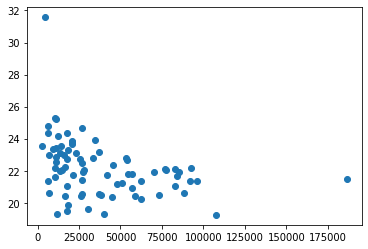

In [44]:
plt.scatter(criminality_by_community,average_violations)

Also the scatter plot does not explain a lot, but it confirms the negative correlation.